<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/hilbert_curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hilbert space fitting curve and potential ways we can use them
### Installing packages

In [ ]:
!pip install mapclassify
!pip install osmnx
!pip install raster_tools
!pip install planetary-computer
!pip install pystac-client
!pip install stackstac
!pip install hilbertcurve

### Importing packages

In [1]:
import geopandas as gpd, pandas as pd
import numpy as np
from hilbertcurve.hilbertcurve import HilbertCurve

c:\Users\jshogland\AppData\Local\miniconda3\envs\rstools\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Let's look at how cells are orginzed within Hilbert space
- Note that cell indexing is based on quadrants in the u-shape space fitting curve
- Increase the level of complexity p (increase the axis) and notice how within quadrants the pattern gets rotated within sub-quadrants but maintains the overall larger indexing or pattern

## Create 2d hilbert curve and visualize as lines and polygons
- For lines print cell nodes and connection lines
- For polygons print color based on hilbert distance (gradient of color denotes order of indexing)

<Axes: >

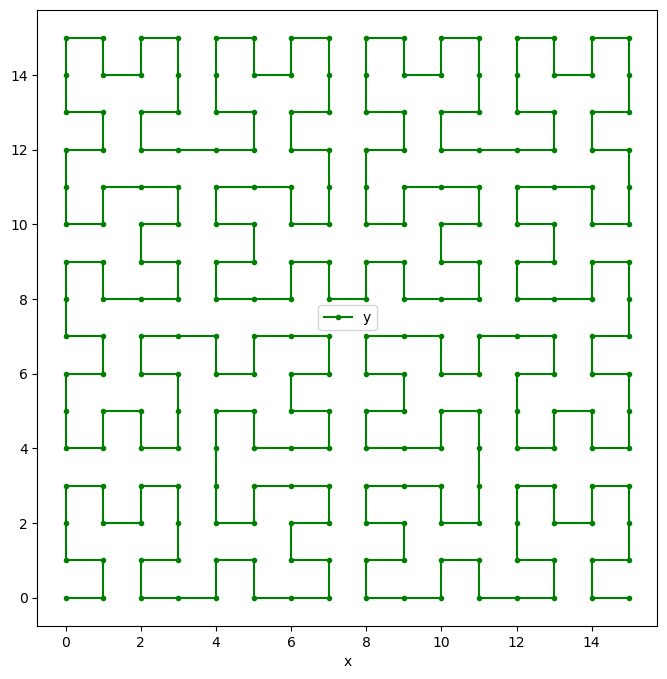

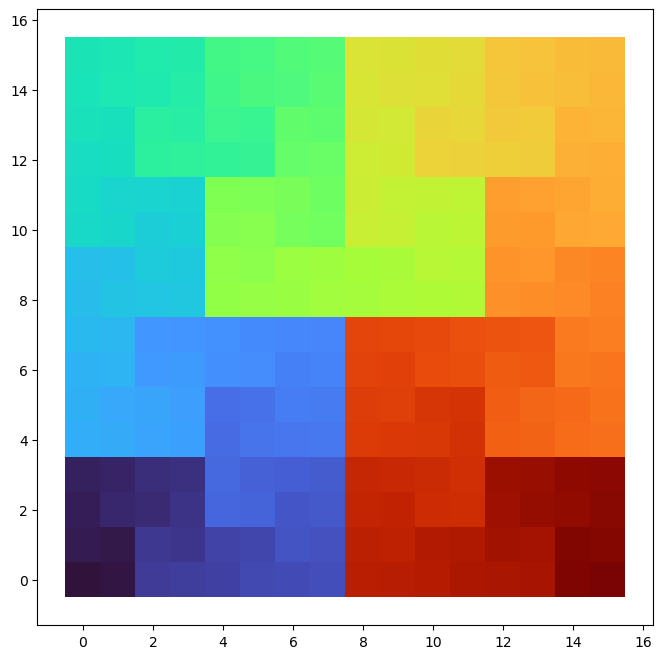

In [63]:
# Specify the Hilbet Curve
pcl=['x','y','z','a','b','c']
n=2 #number of dimensions
p=4 #length of axis
hc=HilbertCurve(p=p,n=n)
dist = range(np.power(2,n*p)) #get all cubes created
pnts=pd.DataFrame(hc.points_from_distances(dist),columns=pcl[:n])
pnts.plot(x='x',y='y',color='green',style='.-',figsize=(8,8))
gdf = gpd.GeoSeries(gpd.points_from_xy(pnts['x'],pnts['y']))
gdf2=gdf.buffer(0.5,cap_style='square')
gpd.GeoDataFrame(dist,columns=['dist'],geometry=gdf2).plot(column='dist',figsize=(8,8),cmap='turbo')

## Visualize 3d rendering of hilbert space fitting curves
- As connected lines in 3d space
- As color coded points in 3d space (color identifies index number/distance)
- Adjust p to see how quadrants change in color and connectivity

In [3]:
# Specify the Hilbet Curve
pcl=['x','y','z','a','b','c']
n=3 #number of dimensions
p=3 #length of axis
hc=HilbertCurve(p=p,n=n)
dist = range(np.power(2,n*p,dtype='object')) #get all cubes created
pnts=pd.DataFrame(hc.points_from_distances(dist),dtype='int32',columns=pcl[:n]) #convert to a dataframe

### Visualize the how each cube is connected (line graph)

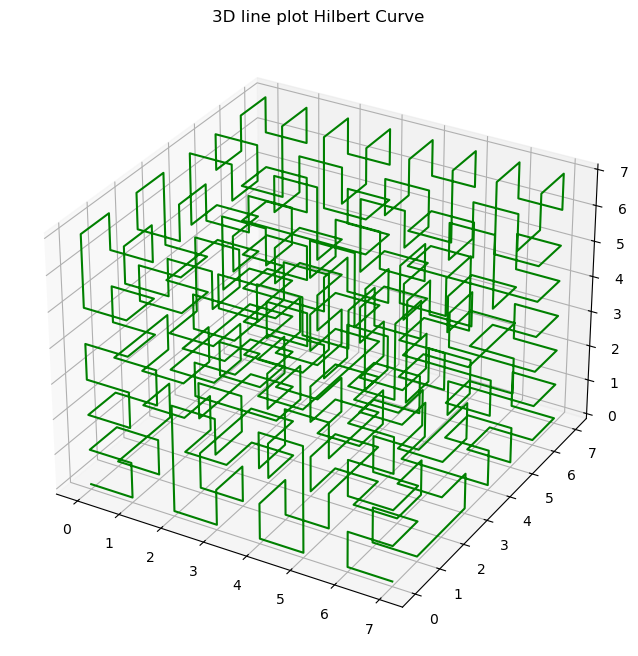

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))

# syntax for 3-D projection
ax = plt.axes(projection ='3d')

# defining all 3 axis
z = pnts['z']
x = pnts['x']
y = pnts['y']

# plotting
ax.plot3D(xs=x, ys=y, zs=z, color='green')
ax.set_title('3D line plot Hilbert Curve')
plt.show()

# Visualize in a dynamic graph and see how connectivity is rotated in the cube depending on the value of p
### Note, colors stays within quadrants

In [5]:
import plotly.express as px
fig = px.scatter_3d(pnts, x='x', y='y', z='z',
              color=list(dist),width=1500,height=800)

fig.show()

# Hilbert space fitting curve properties
### The indexing of finite space in the hilbert curve allows one to easily map from multi-dimensional space to one-dimensional space (distance along the curve). One can think of this distance as the drawing order of each cell within a hypercube and can further use that order to sort similar regions of the hyper cube. This property allows us to compare proximity across all cells and clump like regions which is useful for spreading and clumping. Let's explore how we can systematically sample across hilbert space to reduce sampling variation and further use hilbert distance to cluster like regions.


## Systematic sampling (2d)
- Each dimension is scaled to p units
- Hilbert distance is (cell index) used to order the data
- A well spread and balanced sample is extracted systematically from the ordered cells

<Axes: >

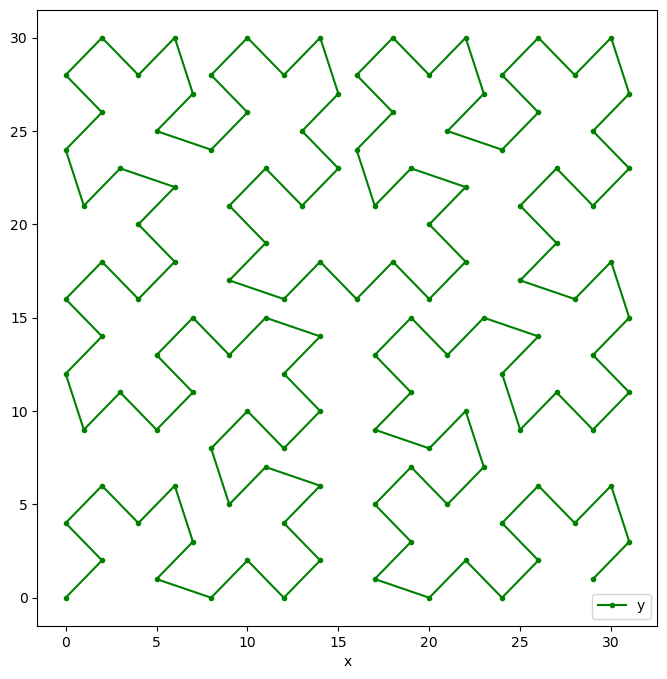

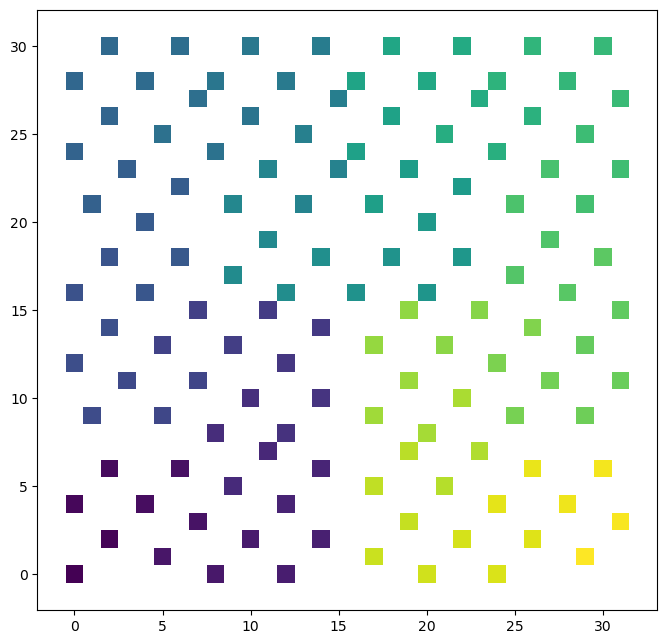

In [6]:
# Specify the Hilbet Curve
pcl=['x','y','z','a','b','c','d','e','f']
n=2 #number of dimensions
p=5 #length of axis
hc=HilbertCurve(p=p,n=n)
ss=128
max_dist=np.power(2,n*p)
sk=max_dist/ss
dist = np.arange(0,max_dist,sk).astype('uint64') #get all cubes created
pnts=pd.DataFrame(hc.points_from_distances(dist),columns=pcl[:n])
pnts.plot(x='x',y='y',color='green',style='.-',figsize=(8,8))
gdf = gpd.GeoSeries(gpd.points_from_xy(pnts['x'],pnts['y']))
gdf2=gdf.buffer(0.5,cap_style='square')
gpd.GeoDataFrame(dist,columns=['dist'],geometry=gdf2).plot(column='dist',figsize=(8,8))

## Systematic Sampling (3d)

In [7]:
# Specify the Hilbet Curve
pcl=['x','y','z','a','b','c']
n=3 #number of dimensions
p=4 #length of axis
hc=HilbertCurve(p=p,n=n)
ss=128
max_dist=np.power(2,n*p)
sk=max_dist/ss
dist = np.arange(0,max_dist,sk).astype('uint64')
pnts=pd.DataFrame(hc.points_from_distances(dist),dtype='uint64',columns=pcl[:n]) #convert to a dataframe
fig = px.scatter_3d(pnts, x='x', y='y', z='z',
              color=dist.astype(float),width=1500,height=800)

fig.show()

# Hilbert space fitting curves can be used to naturally group like values together. One can use this to find clusters within the data. Using Raster Tools' model_predict function we can make a definition that can convert a multi-band raster into a single band raster of Hilbert curve distances. Moreover, we can use Hilbert distance to create like groups or clusters of cells.
- Get landsat data
- Create a Hilbert curve object (n=nbands, p=at least 2 bit number of classes)
- Create a definition that classifies a N*M array into distances as a numpy array
- Add that definition to our Hilbert curve object
- Read in landsat raster and normalize to a value between 0 and 1
- Use Raster Tools' ModelPredictAdapter to create model that can be passed to model_predict
- Apply the model to the normalized raster to create a surface of Hilbert distances
- Use mapclassify to find natural breaks in the density of Hilbert distances (k classes)
- Use those natural breaks to remap Hilbert distances surface to each class
- Plot the results

### Import packages

In [8]:
#import functions
from raster_tools import Raster,general,zonal
import mapclassify
import stackstac, pystac_client, planetary_computer, os, osmnx as ox

### Get Landsat Data

In [9]:
#create definition to mosaic stac data
def mosaic_stac(xr):
    return stackstac.mosaic(xr)

#create definition to extract stac data
def get_stac_data(geo,url="https://planetarycomputer.microsoft.com/api/stac/v1",name="sentinel-2-l2a",res=30,crs=5070,**kwarg):
    '''
    gets tiled data from planetary computer as a dask backed xarray that intersects the geometry of the point, line, or polygon

    geo = (polygon) geometry bounding box (WGS84)
    url = (string) base url to planetary computer https://planetarycomputer.microsoft.com/api/stac/v1
    name = (string) catelog resource
    qry =  (dictoinary) of property values {'eo:cloud_cover':{'lt':1}}
    res = (tuple of numbers) output resolution (x,y)
    crs = (int) output crs
    dt = (string) data time intervale e.g., one month: 2023-06, range: 2023-06-02/2023-06-17
    limit = (int) max number of items to return

    returns (xarray data array and stac item catalog)
    '''
    catalog = pystac_client.Client.open(url, modifier=planetary_computer.sign_inplace)
    srch = catalog.search(collections=name, intersects=geo, **kwarg)
    ic = srch.item_collection()
    if(len(ic.items)>0):
        xra = stackstac.stack(ic,resolution=res,epsg=crs)
        xra = mosaic_stac(xra)
    else:
        xra=None

    return xra,ic

#get stac data
if(not os.path.exists('ls8_g.tif')):
    nf=ox.geocode_to_gdf('Custer Gallatin National Forest, MT, USA')
    #get first polygon of the NF
    nfe=nf.explode()
    nf1=gpd.GeoSeries(nfe.geometry.iloc[10],crs=nf.crs)
    #project to Albers equal area
    nf1p=nf1.to_crs(5070)
    nf1=gpd.GeoSeries(nfe.geometry.iloc[10],crs=nf.crs)
    xmin,ymin,xmax,ymax=nf1p.buffer(30000).total_bounds
    ls30, ic =get_stac_data(nf1.geometry[0],"https://planetarycomputer.microsoft.com/api/stac/v1",name="landsat-c2-l2",res=30,crs=5070,datetime='2023-07-15/2023-07-30',query={'eo:cloud_cover':{'lt':10},'platform':{'eq':'landsat-8'}},limit=1000)
    ls30s=Raster(ls30.sel(band=['red', 'blue', 'green', 'nir08', 'lwir11','swir16', 'swir22'],x=slice(xmin,xmax),y=slice(ymax,ymin)))
    ls30s=ls30s.save('ls8_g.tif')

C:\Users\jshogland\AppData\Local\Temp\ipykernel_23020\3921794872.py:36: FutureWarning:

Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.



In [10]:
#definition to convert hilbert distance output to numpy array
def _calcdist(X):
    return np.array(hc.distances_from_points(X))

#read in raster
ls_rs=Raster('ls8_g.tif').chunk((1,1024,1024))

#define k classes, n dimensions, and p axis length
k=10
n=ls_rs.nbands
p=np.log2(k).astype('int')+1 # a function based on number of k classes

hc=HilbertCurve(p=p,n=n)
hc._calcdist=_calcdist

#use the model adapter to create a model that can be used by our model_predict function
hcp=general.ModelPredictAdaptor(hc,'_calcdist')

### Normalize the landsat band values 0-1*p.
#### Note, we could also use ordination to make orthogonal predictors (PCA analysis on standard normalization variables)

In [11]:
# note we could use sampling here to reduce the amount of processing
bmins=ls_rs.xdata.min(axis=(1,2)).values
bmaxs=ls_rs.xdata.max(axis=(1,2)).values

#normalize the raster
ls_sc=(((ls_rs.bandwise-bmins).bandwise/(bmaxs-bmins))*(2**p-1)).astype('int64')

### Calculate Hilbert distance surface

In [12]:
# create a function that returns remap parameters
def _get_rm_vls(dist,k=10,tech=mapclassify.Quantiles):
    #bin based on quantiles
    qts=tech(dist,10)
    rm=[(0,qts.bins[0],0)]
    for i in range(qts.bins.shape[0]-1):
        vl=qts.bins[i]
        vl2=qts.bins[i+1]
        rm.append((vl,vl2,i+1))
    return rm

# create distance raster
drs=ls_sc.model_predict(hcp,1).load()

### Get remap values using a sample

In [13]:
# make sample of 10K
xs=np.random.choice(drs.x,10000)
ys=np.random.choice(drs.y,10000)

smp=gpd.GeoSeries(gpd.points_from_xy(xs,ys),crs=drs.crs)
tbl=zonal.extract_points_eager(smp,drs,axis=1).compute()

# get remap values using quantiles (can use various options for grouping)
# dist=drs.to_numpy().flatten()
dist=tbl.iloc[:,0]
rm=_get_rm_vls(dist,k=k,tech=mapclassify.JenksCaspallSampled)
rm[-1]=(rm[-1][0],hc.max_h,k-1)

# remap to K classes
c_rs=drs.remap_range(rm,'right')

### Plot the spatial distribution of K clusters

In [14]:
import folium
m=folium.Map()
folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Imagery',
        overlay = False,
        control = True
       ).add_to(m)
m=c_rs.explore(band=1,cmap='terrain',map=m, name='Hilbert Clusters')
#folium.LayerControl().add_to(m)
m

c:\Users\jshogland\AppData\Local\miniconda3\envs\rstools\lib\site-packages\rasterio\warp.py:344: NotGeoreferencedWarning:

Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.



For a more in depth description of Hilbert space filling curves and infinite math, check out Grant Sanderson's youtube channel and video: https://www.youtube.com/watch?v=3s7h2MHQtxc 